# IV. Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
df_dev = pd.read_csv('../Data/DF_Train.csv')
pd.set_option('max_columns',100)
df_dev.head()

BATHRM  HF_BATHRM           HEAT AC  NUM_UNITS  ROOMS  BEDRM     AYB   EYB  \
0       2          1  Hot Water Rad  Y        1.0      8      3  1927.0  1967   
1       1          0  Hot Water Rad  Y        1.0      6      2  1908.0  1967   
2       1          0  Hot Water Rad  Y        1.0      7      3  1925.0  1954   
3       1          0  Hot Water Rad  Y        1.0      7      3  1940.0  1967   
4       2          1     Forced Air  Y        1.0      7      3  2007.0  2011   

  QUALIFIED     GBA  BLDG_NUM          STYLE  STRUCT  GRADE  CNDTN  \
0         Q  2459.0         1  2.5 Story Fin       0      2      0   
1         Q  1285.0         1        2 Story       1      2      1   
2         Q  1200.0         1        2 Story       1      1      0   
3         Q  1308.0         1        2 Story       0      2      1   
4         Q  1460.0         1        2 Story       1      3      1   

        EXTWALL  ROOF   INTWALL  KITCHENS  FIREPLACES  USECODE  LANDAREA  \
0  Common Brick     1  Hardwood       1.0           1       13      2960   
1  Common Brick     1  Hardwood       1.0           0       11       805   
2  Common Brick     0  Hardwood       1.0           0       11      1520   
3  Common Brick     0  Hardwood       1.0           1       11      4453   
4  Brick/Siding     0  Hardwood       1.0           0       11      2060   

   ZIPCODE   LATITUDE  LONGITUDE ASSESSMENT_NBHD  CENSUS_TRACT    WARD  \
0  20012.0  38.970914 -77.034953      Brightwood        1803.0  Ward 4   
1  20003.0  38.882655 -76.985923      Old City 1        6900.0  Ward 6   
2  20002.0  38.899192 -76.975985        Trinidad        8904.0  Ward 5   
3  20017.0  38.945422 -76.988941       Brookland        9504.0  Ward 5   
4  20018.0  38.923109 -76.958568    Fort Lincoln        9000.0  Ward 5   

   SQUARE QUADRANT     PRICE  SALEYEAR  ayb_age  eyb_age  
0    2732       NW  185000.0      1995     91.0       51  
1    1043       SE  211000.0      2003    110.0       51  
2    4506       NE  145000.0      2003     93.0       64  
3    3916       NE  640000.0      2016     78.0       51  
4    4325       NE  419900.0      2018     11.0        7

In [3]:
df_dev.shape

(41972, 35)

In [4]:
df_dev.columns

Index(['BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM',
       'AYB', 'EYB', 'QUALIFIED', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT',
       'GRADE', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS',
       'FIREPLACES', 'USECODE', 'LANDAREA', 'ZIPCODE', 'LATITUDE', 'LONGITUDE',
       'ASSESSMENT_NBHD', 'CENSUS_TRACT', 'WARD', 'SQUARE', 'QUADRANT',
       'PRICE', 'SALEYEAR', 'ayb_age', 'eyb_age'],
      dtype='object')

## Model Training

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, PoissonRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [6]:
# Dictionary to keep the assessment of each model
model_assessment = []

# Funtion to assess the model performance
def assess_model(model, model_key, poly=False):
    if poly==True:
        dataset = [[X_train_pr, y_train, 'Training'], [X_val_pr, y_val, 'Validation']]
    else:
        dataset = [[X_train_prepared, y_train, 'Training'], [X_val_prepared, y_val, 'Validation']]
    
    for data in dataset:
        y_pred = model.predict(data[0])
        
        model_assessment.append([model_key,
                               data[2],
                               mean_squared_error(data[1], y_pred),
                               np.sqrt(mean_squared_error(data[1], y_pred)),
                               mean_absolute_error(data[1], y_pred),
                               r2_score(data[1], y_pred)])
        
        print(data[2])
        print('MSE: {}'.format(mean_squared_error(data[1], y_pred)))
        print('RMSE: {}'.format(np.sqrt(mean_squared_error(data[1], y_pred))))
        print('MAE: {}'.format(mean_absolute_error(data[1], y_pred)))
        print('R-squared: {}'.format(r2_score(data[1], y_pred)))
        print('\n')

### 1. Linear Regression

In [7]:
# Splitting Training & Validation Set
num_cols = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM', 'GBA', 'ayb_age', 'eyb_age', 'KITCHENS', 'FIREPLACES', 'LANDAREA', 'NUM_UNITS', 'LATITUDE', 'LONGITUDE']
onehot_cols = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT', 'HEAT', 'STYLE', 'USECODE', 'ASSESSMENT_NBHD', 'EXTWALL', 'INTWALL']
ordinal_cols = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR']
label = ['PRICE']

X = df_dev[num_cols + onehot_cols + ordinal_cols]
y = df_dev['PRICE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=22)

# Scaling & Encoding
col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols)
])

X_train_prepared = col_transformer.fit_transform(X_train)
X_val_prepared = col_transformer.transform(X_val)

In [8]:
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

In [9]:
assess_model(lin_reg, 'Linear Regression')

Training
MSE: 18826241487.318348
RMSE: 137208.75149682816
MAE: 103916.96844143042
R-squared: 0.8065725278712927


Validation
MSE: 19027044854.16924
RMSE: 137938.55463273943
MAE: 104536.59379231013
R-squared: 0.8037192507584976




In the Multiple Linear Regression model, we get an underfitting result, so we will try to increase the model's complexity with Polynomial Regression. We do not try using Ridge/Lasso to improve the result of this model as performing Ridge/Lasso will not improve the model significantly because of the underfitting result and there is no multicollinearity in our data.

### 2. Polynomial Regression

In [10]:
# Select different features for polynomial
num_cols_pr = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM','ayb_age', 'eyb_age', 'GBA', 'KITCHENS', 'FIREPLACES']
onehot_cols_pr = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT']
ordinal_cols_pr = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR']
label_pr = ['PRICE']

X_pr = df_dev[num_cols_pr + onehot_cols_pr + ordinal_cols_pr]
y_pr = df_dev['PRICE']

X_train_p, X_val_p, y_train_p, y_val_p = train_test_split(X_pr, y_pr, test_size=0.25, random_state=22)

col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols_pr),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'), onehot_cols_pr),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols_pr)
])

X_train_prepared_pr = col_transformer.fit_transform(X_train_p)
X_val_prepared_pr = col_transformer.transform(X_val_p)

In [11]:
pr = PolynomialFeatures(degree=2, include_bias=False)

X_train_pr = pr.fit_transform(X_train_prepared_pr)
X_val_pr = pr.transform(X_val_prepared_pr)

In [12]:
lin_reg = LinearRegression()

lin_reg.fit(X_train_pr, y_train_p)

LinearRegression()

In [13]:
assess_model(lin_reg, 'Polynomial Regression', poly=True)

Training
MSE: 13549379714.497149
RMSE: 116401.80288336237
MAE: 84759.31643044768
R-squared: 0.8607888744626697


Validation
MSE: 13973331023.878181
RMSE: 118208.84494773723
MAE: 85763.94755283285
R-squared: 0.8558527662184306




After we try to increase the model's complexity with Polynomial Regression and reduce the features, we get a better result. Since the result does not overfit, we will not try to regularize it with Ridge/Lasso.

### 3. Decision Tree Regressor

In [14]:
# Splitting Training & Validation Set
num_cols = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM','ayb_age', 'eyb_age', 'GBA', 'KITCHENS', 'FIREPLACES', 'LANDAREA', 'LATITUDE', 'LONGITUDE']
onehot_cols = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT', 'HEAT', 'STYLE', 'USECODE']
ordinal_cols = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR']
label = ['PRICE']

X = df_dev[num_cols + onehot_cols + ordinal_cols]
y = df_dev['PRICE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=22)

# Scaling & Encoding
col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols)
])

X_train_prepared = col_transformer.fit_transform(X_train)
X_val_prepared = col_transformer.transform(X_val)

In [15]:
dt = DecisionTreeRegressor(random_state=22)
dt.fit(X_train_prepared, y_train)

DecisionTreeRegressor(random_state=22)

In [16]:
assess_model(dt, 'Decision Tree Regressor')

Training
MSE: 5607.093766214514
RMSE: 74.88052995415106
MAE: 1.0043944640342233
R-squared: 0.999999942390733


Validation
MSE: 20107417977.584675
RMSE: 141800.62756414257
MAE: 92944.70161059753
R-squared: 0.792574249117431




Since decision tree gives an overfit model, we try random forest to address this issue and to reduce the variance. Random forest will split the training data into multiple samples with replacement (bootstrap sample) and then makes a tree for each bootstrap sample with feature randomization. The majority vote will be the final result.

### 4. Random Forest

In [17]:
rf = RandomForestRegressor(random_state=22)
rf.fit(X_train_prepared, y_train)

RandomForestRegressor(random_state=22)

In [18]:
assess_model(rf, 'Random Forest Regressor')

Training
MSE: 1352592053.5643857
RMSE: 36777.602607625005
MAE: 23845.001978334763
R-squared: 0.9861029902373996


Validation
MSE: 9229199529.253033
RMSE: 96068.72295004776
MAE: 62796.01593652117
R-squared: 0.9047926668389514




### 4.1 Random Forest - Tuned

In [19]:
rf = RandomForestRegressor(min_samples_leaf=9, random_state=22)
rf.fit(X_train_prepared, y_train)

RandomForestRegressor(min_samples_leaf=9, random_state=22)

In [20]:
assess_model(rf, 'Random Forest Regressor - Tuned')

Training
MSE: 6406655207.190864
RMSE: 80041.58423713803
MAE: 52286.6110477499
R-squared: 0.9341757555610923


Validation
MSE: 9932636199.451372
RMSE: 99662.61184341584
MAE: 65918.27641512352
R-squared: 0.8975360971651681




In [21]:
# # The Random Forest model resulted from the RandomizedSearchCV does not give a better result compared to the Random Forest we tuned manually.
# rf_parameters = {
#     'max_depth': [None, 3, 5, 7, 9, 11, 13, 20],
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_leaf': [5, 9, 10, 15, 20, 25],
#     'min_samples_split': [1, 5, 9, 10, 15, 20, 25],
#     'n_estimators': [100, 200, 300, 350],
#     'bootstrap':[True, False]
# }

# rf = RandomForestRegressor(random_state=22)
# random_rf = RandomizedSearchCV(rf, rf_parameters)
# random_rf.fit(X_train_prepared, y_train)
# random_rf.best_estimator_

In [22]:
# random_rf.best_estimator_.fit(X_train_prepared, y_train)
# assess_model(random_rf.best_estimator_, 'Random Forest Tuned with RandomizedSearchCV')

In [23]:
# The GridSearcCV takes a really long time to run and our computers do not have enough capacity to perform it, so we tune the parameters manually.

# rf_parameters = {
#     'criterion' : ['mse','mae'],
#     'max_depth': [3, 5, 7, 9, 11, 13, 20],
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_leaf': [5, 9, 20, 50, 100],
#     'min_samples_split': [5, 9, 20, 50, 100],
#     'n_estimators': [10, 50, 100, 200, 300, 350],
#     'bootstrap':[True, False]
# }

# rf = RandomForestRegressor(random_state=22)
# grid_rf = GridSearchCV(rf, rf_parameters)
# grid_rf.fit(X_train_prepared, y_train)
# grid_rf.best_estimator_

### 5. Voting Regressor

In [21]:
from sklearn.ensemble import VotingRegressor

In [22]:
ridge = Ridge()

In [23]:
estimators = [
    ('lin_reg', lin_reg),
    ('ridge', ridge),
    ('dt', dt),
    ('rf', rf)
]

In [24]:
np.random.seed(22)
voting_reg = VotingRegressor(
    estimators=estimators
)

voting_reg.fit(X_train_prepared, y_train.ravel())

VotingRegressor(estimators=[('lin_reg', LinearRegression()), ('ridge', Ridge()),
                            ('dt', DecisionTreeRegressor(random_state=22)),
                            ('rf',
                             RandomForestRegressor(min_samples_leaf=9,
                                                   random_state=22))])

In [25]:
assess_model(voting_reg, 'Voting Regressor')

Training
MSE: 7342565282.9753065
RMSE: 85688.76987666065
MAE: 63365.21544605495
R-squared: 0.9245598840011361


Validation
MSE: 12428257471.259295
RMSE: 111482.09484603029
MAE: 79979.0996618043
R-squared: 0.8717915626456022




### 6. CatBoost Regressor

In [26]:
from sklearn.base import BaseEstimator

In [27]:
# Splitting Training & Validation Set
num_cols = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM','ayb_age', 'eyb_age', 'GBA', 'KITCHENS', 'FIREPLACES', 'LANDAREA', 'LATITUDE', 'LONGITUDE']
cat_cols = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT', 'HEAT', 'STYLE', 'USECODE']
ordinal_cols = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR']
label = ['PRICE']

X = df_dev[num_cols + cat_cols + ordinal_cols]
y = df_dev['PRICE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=22)

class NoTransformer(BaseEstimator):
    # Passes through data without any change and is compatible with ColumnTransformer class
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X

# Scaling & Encoding
col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols),
    ('no_transformer', NoTransformer(), cat_cols)
])

new_col_names = num_cols + ordinal_cols + cat_cols

X_train_prepared = pd.DataFrame(col_transformer.fit_transform(X_train, y_train), columns=new_col_names)
X_val_prepared = pd.DataFrame(col_transformer.transform(X_val), columns=new_col_names)

In [28]:
catboost = CatBoostRegressor(verbose=False)
catboost.fit(X_train_prepared, y_train, cat_features=cat_cols)

In [29]:
assess_model(catboost, 'CatBoost Regressor')

Training
MSE: 5849415231.978269
RMSE: 76481.46986021037
MAE: 51988.49933492106
R-squared: 0.9399010364062914


Validation
MSE: 7854494488.953314
RMSE: 88625.58597241157
MAE: 58064.52222991583
R-squared: 0.9189739617990551




### 6. CatBoost Regressor - Tuned (FINAL MODEL)

In [33]:
from catboost import Pool

In [31]:
train_pool = Pool(X_train_prepared, y_train, cat_features=cat_cols)

In [32]:
catboost_tuned = CatBoostRegressor(loss_function='MAE', verbose=False)

grid = {'learning_rate': [0.03, 0.05, 0.07, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'border_count' : [32, 255]
       }

grid_search_result = catboost_tuned.grid_search(grid, 
                                       X=train_pool,
                                       plot=True,
                                       verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 64504.46602
bestIteration = 999


bestTest = 62268.1313
bestIteration = 999


bestTest = 61393.27174
bestIteration = 998


bestTest = 61193.69276
bestIteration = 999


bestTest = 64534.78968
bestIteration = 999


bestTest = 62185.67452
bestIteration = 999


bestTest = 61529.53052
bestIteration = 998


bestTest = 61134.07742
bestIteration = 996


bestTest = 64474.56918
bestIteration = 999


bestTest = 62210.26745
bestIteration = 999


bestTest = 61548.04299
bestIteration = 999


bestTest = 60906.04515
bestIteration = 999


bestTest = 64513.43128
bestIteration = 999


bestTest = 62254.41076
bestIteration = 998


bestTest = 61553.95443
bestIteration = 999


bestTest = 60922.79777
bestIteration = 999


bestTest = 64491.53521
bestIteration = 999


bestTest = 62292.45027
bestIteration = 999


bestTest = 61604.71214
bestIteration = 999


bestTest = 61023.20386
bestIteration = 998


bestTest = 60919.03858
bestIteration = 999


bestTest = 60051.89267
bestIteration = 999


bestTest =

In [37]:
assess_model(catboost_tuned, 'CatBoost Regressor - Tuned')

Training
MSE: 5612305566.310851
RMSE: 74915.32264037078
MAE: 45510.50557337333
R-squared: 0.9423371850809074


Validation
MSE: 7863497379.003791
RMSE: 88676.36313586496
MAE: 56813.04275227572
R-squared: 0.9188810890477692




In [34]:
catboost_tuned.get_params()

{'learning_rate': 0.07,
 'depth': 8,
 'l2_leaf_reg': 5,
 'loss_function': 'MAE',
 'border_count': 255,
 'verbose': False}

### Feature Importance and SHAP

In [38]:
# Make a feature importances dataframe
df_feature_importances = pd.DataFrame(catboost_tuned.feature_importances_, new_col_names).reset_index().rename(columns={'index':'Features', 0:'Score'})
df_feature_importances

Features      Score
0       BATHRM   3.636797
1    HF_BATHRM   0.686077
2        ROOMS   0.763878
3        BEDRM   0.882016
4      ayb_age   2.982336
5      eyb_age   3.692047
6          GBA   7.516157
7     KITCHENS   0.153395
8   FIREPLACES   1.674842
9     LANDAREA   2.187913
10    LATITUDE   4.593569
11   LONGITUDE   9.397263
12      STRUCT   0.074494
13       GRADE   8.947983
14       CNDTN   2.964498
15        ROOF   0.127155
16    SALEYEAR  28.768138
17          AC   0.394394
18   QUALIFIED   3.811541
19        WARD  13.913146
20    QUADRANT   0.867292
21        HEAT   0.396924
22       STYLE   0.502920
23     USECODE   1.065226

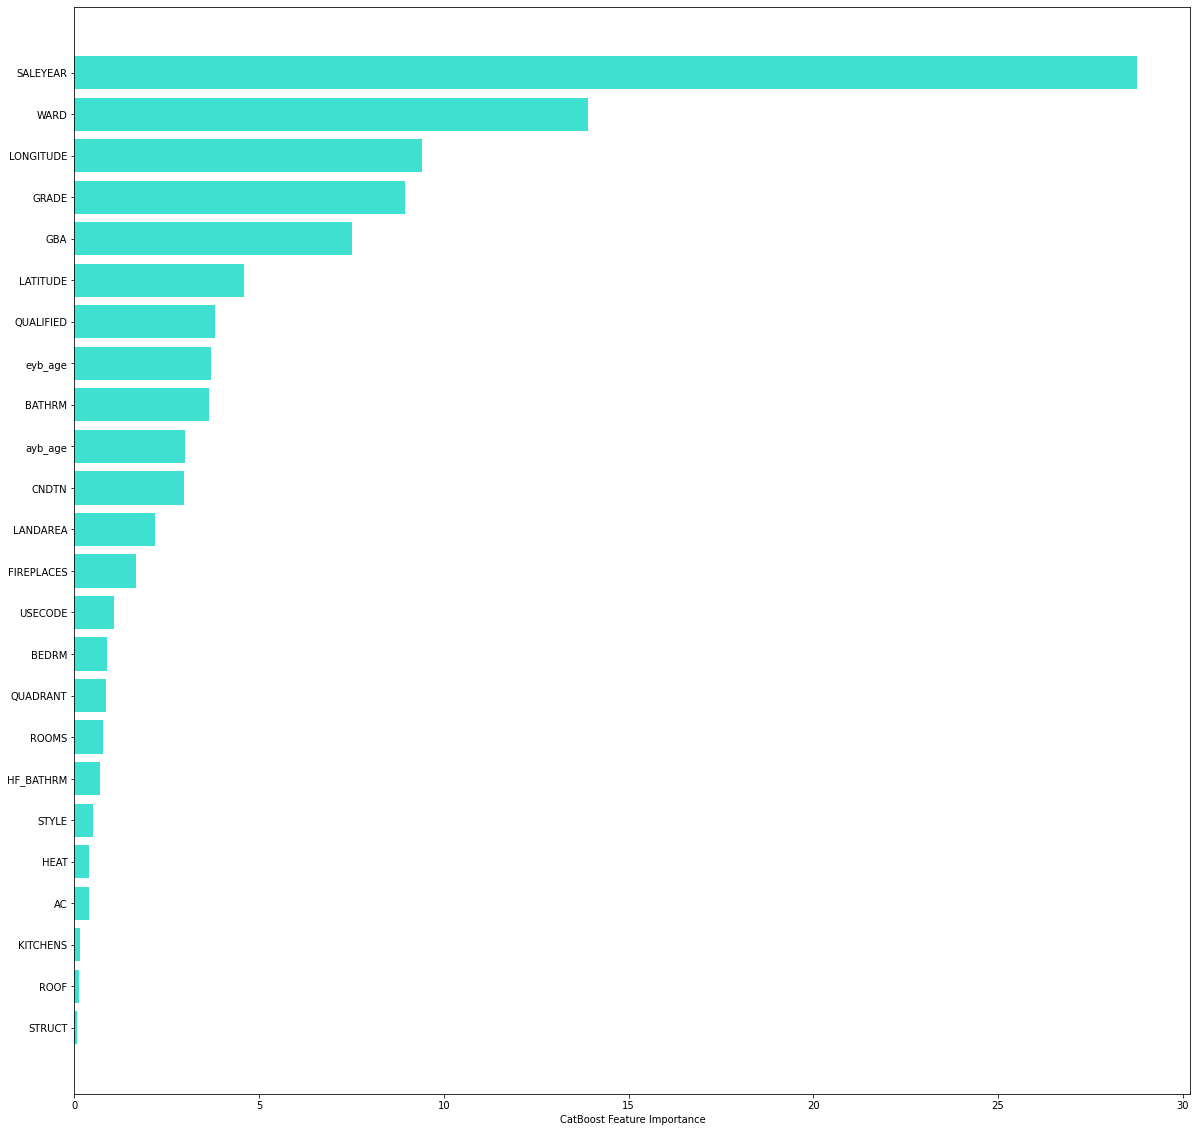

In [39]:
plt.figure(figsize=(20,20))
plt.barh(width='Score', 
         y='Features',
         data=df_feature_importances.sort_values(by='Score'),
         color='turquoise')
plt.xlabel("CatBoost Feature Importance");

In [40]:
import shap

Reference for shap : https://github.com/slundberg/shap

In [41]:
explainer = shap.Explainer(catboost_tuned)
shap_values = explainer(X_train_prepared)

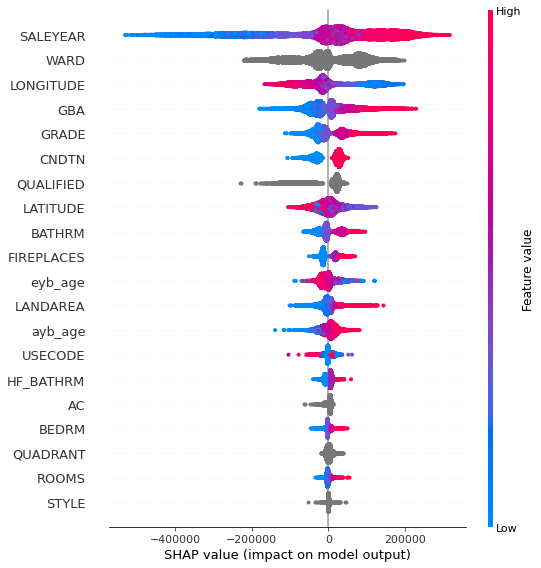

In [42]:
shap.summary_plot(shap_values)

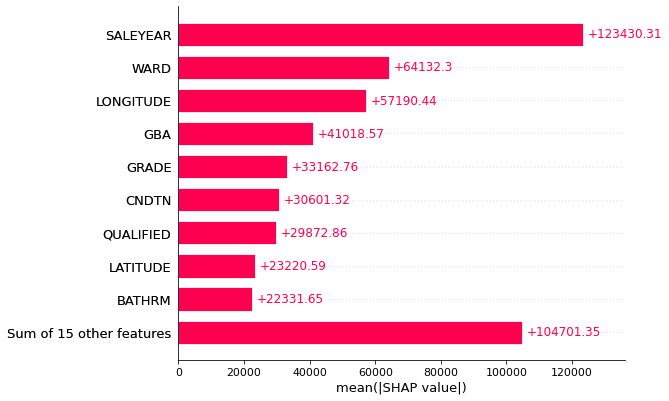

In [43]:
shap.plots.bar(shap_values)

From the CatBoost Feature Importance and SHAP Value (Summary Plot) above, we obtain several insights:
- The most important feature is `SALEYEAR`. The `SALEYEAR` Data also have a long datapoints spread, which would affect the prediction result proportionally. The lower the `SALEYEAR`, the result would be more affected negatively, and vice versa.
- There are grey colours in SHAP Value plot, this shows the categorical columns that is used as cat_cols in CatBoost Regressor model.
- The five most important features are `SALEYEAR`, `WARD`, `LONGITUDE`, `GBA`, and `QUALIFIED`.

### Model Assessment

In [31]:
# Store all assessment results in a dataframe
df_model_result = pd.DataFrame(data=model_assessment, columns=['Model', 'Set', 'MSE', 'RMSE', 'MAE', 'R2'])
df_model_result

Model         Set           MSE           RMSE  \
0                 Linear Regression    Training  1.882624e+10  137208.751497   
1                 Linear Regression  Validation  1.902704e+10  137938.554633   
2             Polynomial Regression    Training  1.354938e+10  116401.802883   
3             Polynomial Regression  Validation  1.397333e+10  118208.844948   
4           Decision Tree Regressor    Training  5.607094e+03      74.880530   
5           Decision Tree Regressor  Validation  2.010742e+10  141800.627564   
6           Random Forest Regressor    Training  1.352592e+09   36777.602608   
7           Random Forest Regressor  Validation  9.229200e+09   96068.722950   
8   Random Forest Regressor - Tuned    Training  6.406655e+09   80041.584237   
9   Random Forest Regressor - Tuned  Validation  9.932636e+09   99662.611843   
10                 Voting Regressor    Training  7.342565e+09   85688.769877   
11                 Voting Regressor  Validation  1.242826e+10  111482.094846   
12               CatBoost Regressor    Training  5.849415e+09   76481.469860   
13               CatBoost Regressor  Validation  7.854494e+09   88625.585972   

              MAE        R2  
0   103916.968441  0.806573  
1   104536.593792  0.803719  
2    84759.316430  0.860789  
3    85763.947553  0.855853  
4        1.004394  1.000000  
5    92944.701611  0.792574  
6    23845.001978  0.986103  
7    62796.015937  0.904793  
8    52286.611048  0.934176  
9    65918.276415  0.897536  
10   63365.215446  0.924560  
11   79979.099662  0.871792  
12   51988.499335  0.939901  
13   58064.522230  0.918974

In [32]:
df_model_result[(df_model_result['Set'] == 'Validation')]

Model         Set           MSE           RMSE  \
1                 Linear Regression  Validation  1.902704e+10  137938.554633   
3             Polynomial Regression  Validation  1.397333e+10  118208.844948   
5           Decision Tree Regressor  Validation  2.010742e+10  141800.627564   
7           Random Forest Regressor  Validation  9.229200e+09   96068.722950   
9   Random Forest Regressor - Tuned  Validation  9.932636e+09   99662.611843   
11                 Voting Regressor  Validation  1.242826e+10  111482.094846   
13               CatBoost Regressor  Validation  7.854494e+09   88625.585972   

              MAE        R2  
1   104536.593792  0.803719  
3    85763.947553  0.855853  
5    92944.701611  0.792574  
7    62796.015937  0.904793  
9    65918.276415  0.897536  
11   79979.099662  0.871792  
13   58064.522230  0.918974

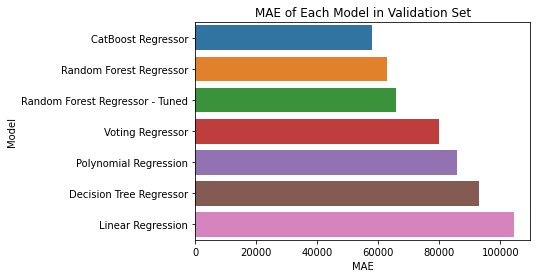

In [33]:
sns.barplot(data=df_model_result[(df_model_result['Set'] == 'Validation')].sort_values(by='MAE'),
            x='MAE', y='Model')
plt.title('MAE of Each Model in Validation Set')
plt.savefig('../Model/Model.png', bbox_inches = 'tight')
plt.show()

### Cross Validation

In [47]:
catboost_tuned = CatBoostRegressor(verbose=False, 
                                   loss_function='MAE', 
                                   border_count=255, 
                                   depth=8, 
                                   l2_leaf_reg=5, 
                                   learning_rate=0.07,
                                   cat_features=cat_cols)

In [48]:
scores_train = cross_val_score(catboost_tuned, X_train_prepared, y_train, cv=5, scoring='r2')
print('Training Cross Validation Scores')
print('Mean :', scores_train.mean())
print('Std :', scores_train.std())

Training Cross Validation Scores
Mean : 0.9158643340746657
Std : 0.003152676651029341


## Final Model

We use CatBoost Regressor as our final model as it gives the best R$^2$ results in both training and validation set and the lowest MAE compared with other models. CatBoost Regressor is also more resource efficient than Random Forest Regressor. 

### Re-train Model

In [49]:
num_cols = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM','ayb_age', 'eyb_age', 'GBA', 'KITCHENS', 'FIREPLACES', 'LANDAREA', 'LATITUDE', 'LONGITUDE']
cat_cols = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT', 'HEAT', 'STYLE', 'USECODE']
ordinal_cols = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR']
label = ['PRICE']

# Data Pre-processing
X_train = df_dev[num_cols + cat_cols + ordinal_cols]
y_train = df_dev['PRICE']

# Scaling & Encoding
col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols),
    ('no_transformer', NoTransformer(), cat_cols)
])

new_col_names = num_cols + ordinal_cols + cat_cols

X_train_prepared = pd.DataFrame(col_transformer.fit_transform(X_train, y_train), columns=new_col_names)

In [51]:
catboost_final = CatBoostRegressor(verbose=False, 
                                   loss_function='MAE', 
                                   border_count=255, 
                                   depth=8, 
                                   l2_leaf_reg=5, 
                                   learning_rate=0.07, 
                                   cat_features=cat_cols)

catboost_final.fit(X_train_prepared, y_train, verbose=100)

0:	learn: 235748.1653585	total: 131ms	remaining: 2m 10s
100:	learn: 64544.3384770	total: 15s	remaining: 2m 13s
200:	learn: 57835.6158325	total: 29.5s	remaining: 1m 57s
300:	learn: 54349.0559670	total: 44.4s	remaining: 1m 43s
400:	learn: 52161.6101506	total: 1m 1s	remaining: 1m 32s
500:	learn: 50584.1451401	total: 1m 18s	remaining: 1m 17s
600:	learn: 49339.6309258	total: 1m 35s	remaining: 1m 3s
700:	learn: 48420.2118377	total: 1m 58s	remaining: 50.7s
800:	learn: 47662.1678705	total: 2m 17s	remaining: 34.2s
900:	learn: 46974.7312162	total: 2m 30s	remaining: 16.6s
999:	learn: 46302.8146156	total: 2m 45s	remaining: 0us


In [53]:
# Dictionary that contains col_transformer & final model
model_dict = {
    'transformer' : col_transformer,
    'model' : catboost_final
}

In [54]:
y_pred = model_dict['model'].predict(model_dict['transformer'].transform(X_train))

print('MSE: {}'.format(mean_squared_error(y_train, y_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_train, y_pred)))
print('R-squared: {}'.format(r2_score(y_train, y_pred)))
print('\n')

MSE: 5902490242.367122
RMSE: 76827.66586567057
MAE: 46975.76563974304
R-squared: 0.9392950310981597




#### Target Metrics Evaluation

In [57]:
price_med = df_dev['PRICE'].median()
desired_mae = 0.12 * price_med

print('Price Median : {}\nDesired MAE (12% x Median) : {}\nAchieved MAE : {}'.format(price_med, 
                                                                                     desired_mae,
                                                                                     mean_absolute_error(y_train, y_pred)))

Price Median : 422970.0
Desired MAE (12% x Median) : 50756.4
Achieved MAE : 46975.76563974304


##### From the result shown above, we have achieved the desired MAE metrics value of below USD50,756.4.

---

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


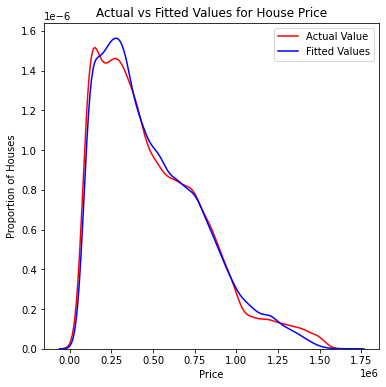

In [58]:
# Distribution plot
plt.figure(figsize=(6, 6))

ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for House Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Houses')

plt.legend()
plt.show()
plt.close()

In [59]:
df_results = pd.DataFrame({
    'Actual': y_train.tolist(),
    'Prediction': y_pred.tolist()
})

df_results['Error'] = df_results['Prediction'] - df_results['Actual']
df_results

Actual     Prediction          Error
0      185000.0  192290.603867    7290.603867
1      211000.0  354111.597321  143111.597321
2      145000.0  140281.729797   -4718.270203
3      640000.0  530784.203404 -109215.796596
4      419900.0  525733.831730  105833.831730
...         ...            ...            ...
41967  345000.0  331610.618724  -13389.381276
41968  285000.0  325010.926190   40010.926190
41969  661500.0  755505.395336   94005.395336
41970  400000.0  406228.954393    6228.954393
41971  298000.0  292554.163346   -5445.836654

[41972 rows x 3 columns]

In [60]:
df_results[['Error']].describe()

Error
count  4.197200e+04
mean  -1.380823e+02
std    7.682846e+04
min   -6.722211e+05
25%   -2.745736e+04
50%   -5.578911e+01
75%    2.688776e+04
max    1.072777e+06

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Error'>

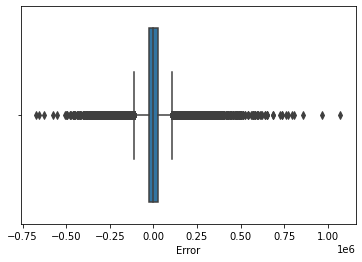

In [61]:
sns.boxplot(df_results['Error'])

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


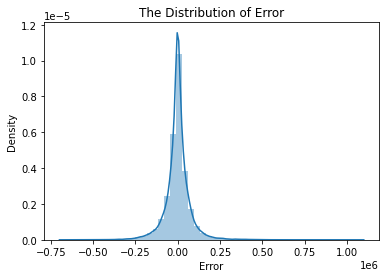

In [62]:
sns.distplot(df_results['Error'])
plt.title("The Distribution of Error")
plt.show()

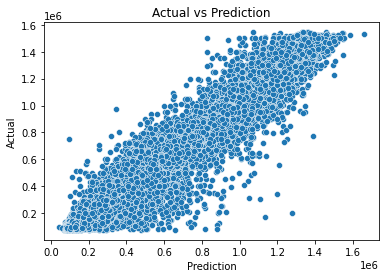

In [63]:
# Residual Analysis
sns.scatterplot(x='Prediction', y='Actual', data=df_results)
plt.title("Actual vs Prediction")
plt.show()

From the analysis results above, we can see that there are many outliers in residuals, so we decide to use MAE as our standard error instead of RMSE as RMSE is very sensitive to outliers. 

In [67]:
scores_train = cross_val_score(model_dict['model'], X_train, y_train, cv=5, scoring='r2', error_score="raise")
print('Training Cross Validation Scores')
print('Mean :', scores_train.mean())
print('Std :', scores_train.std())

Training Cross Validation Scores
Mean : 0.9174836341473466
Std : 0.0011462151706577988


### Evaluate Model

In [78]:
df_test = pd.read_csv('../Data/DF_Test.csv')

X_test = df_test[num_cols + cat_cols + ordinal_cols]
y_test = df_test['PRICE']

y_pred = model_dict['model'].predict(model_dict['transformer'].transform(X_test))

print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('R-squared: {}'.format(r2_score(y_test, y_pred)))
print('\n')

MSE: 10815149410.215195
RMSE: 103995.91054563249
MAE: 63782.41628337468
R-squared: 0.9073119043829377




The model can generalize well on the test data which are unknown instances.

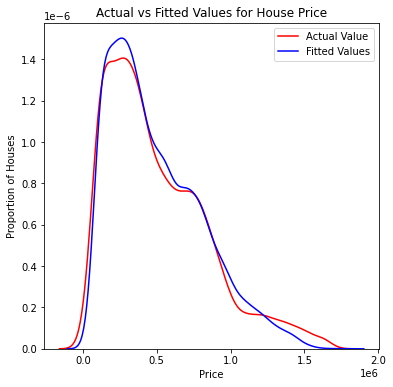

In [79]:
# Distribution plot
plt.figure(figsize=(6, 6))

ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for House Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Houses')
plt.legend()
plt.show()
plt.close()

### Save Model

In [80]:
import pickle
import warnings
warnings.filterwarnings('ignore')

# Pickle the model
pickle_filename = '../Model/Final_Model_Catboost_v2.sav'
with open(pickle_filename, 'wb') as f:
    pickle.dump(model_dict, f)

In [81]:
# Clean df_train and df_test ready for prediction
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [86]:
# Export clean df_train to csv
df_train.to_csv('../Data/DF_Train_Clean.csv', index=False)

In [87]:
# Export clean df_test to csv
df_test.to_csv('../Data/DF_Test_Clean.csv', index=False)